## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score

from src.models.model_relu_no_dropout import GraphClassifier
from src.graphs.graph_loader import GraphDataset
from src.elastic_search_utils.elastic_utils import save_json, load_json

## Params

In [2]:
TEST_FILE_NAME = 'test_original_10b-testset5.json'

In [3]:
LOAD_FOLDER = '/datasets/johan_tests_original_format_graphs_bm25/similarity_shape_100_20__score_threshold_006__similarity_relevance_07/testset5'

In [4]:
LOAD_QUESTIONS_FOLDER = '/datasets/johan_tests_original_format/merged_training_docs'
LOAD_QUESTIONS = f'{LOAD_QUESTIONS_FOLDER}/{TEST_FILE_NAME}'

In [5]:
LOAD_MODEL_PATH = '/datasets/johan_tests_models/v1/model.pth'

In [6]:
SAVING_FOLDER = '/datasets/johan_tests_original_format_graphs_bm25/similarity_shape_100_20__score_threshold_006__similarity_relevance_07'
SAVING_PATH = f'{SAVING_FOLDER}/{TEST_FILE_NAME}'

## Dataset params

In [7]:
BATCH_SIZE = 256

In [8]:
VAL_PERCENTAGE = 0.15
TEST_PERCENTAGE = 0.15

In [9]:
RELEVANCE_THRESHOLD = 10

In [10]:
RANDOM_STATE = 42

In [11]:
torch.manual_seed(RANDOM_STATE)

## Model params

In [12]:
INPUT_DIM = 20
NODES_PER_GRAPH = 100
HIDDEN_CHANNELS = 16
OUTPUT_DIM = 2  # N_CLASSES
DROPOUT = 0.5

In [13]:
DEVICE = torch.device('cuda')

In [14]:
EPOCHS = 100

## Constants

In [15]:
questions = load_json(LOAD_QUESTIONS)

In [16]:
dataset = GraphDataset(
    dataset_path=LOAD_FOLDER,
    batch_size=BATCH_SIZE,
    val_percentage=VAL_PERCENTAGE,
    test_percentage=TEST_PERCENTAGE,
    random_state=RANDOM_STATE,
    score_threshold=RELEVANCE_THRESHOLD
)

In [17]:
model = GraphClassifier(
    input_dims=INPUT_DIM,
    nodes_per_graph=NODES_PER_GRAPH,
    hidden_channels=HIDDEN_CHANNELS,
    output_dim=OUTPUT_DIM,
    dropout=DROPOUT
)

model = model.to(DEVICE)

In [18]:
model.load_state_dict(torch.load(LOAD_MODEL_PATH))

<All keys matched successfully>

In [19]:
flat_labels = dataset.metadata['label'].tolist()
class_weights = compute_class_weight(
    'balanced', classes=[0,1], y=flat_labels
)
class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(DEVICE)

In [20]:
criterion = torch.nn.CrossEntropyLoss(
    weight=class_weights
)
criterion = criterion.to(DEVICE)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-3)

## Prediction loop

In [22]:
y_pred = []
batch_pbar_val = tqdm(
    dataset.get_batch(),
    desc='loss = inf'
)
for test_batch in batch_pbar_val:
    test_batch = test_batch.to(DEVICE)
    out_test = model(test_batch)
    y_pred.append(out_test.tolist())
    test_batch.to('cpu')
    del out_test
    torch.cuda.empty_cache()
y_pred = np.concatenate(y_pred)

loss = inf: 31it [00:09,  3.18it/s]


In [23]:
dataset.metadata['is_relevant'] = y_pred.argmax(axis=1)

### Dictionary for fast removal of documents

In [24]:
final_relevant_documents = {}
for question, relevant_documents in dataset.metadata[
    dataset.metadata['is_relevant'] == 1
].groupby('question_id'):
    final_relevant_documents[question] = relevant_documents['document_id'].unique()

## Removing irrelevant documents from question dict

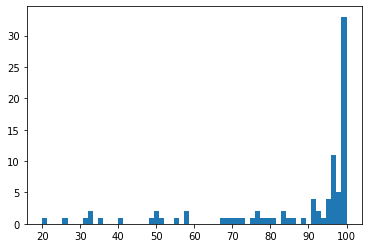

In [25]:
len_docs = [len(question['documents']) for question in questions['questions']]
plt.hist(len_docs, bins = 60)
plt.show()

In [26]:
pd.Series(len_docs).describe()

count     90.000000
mean      85.500000
std       21.090628
min       20.000000
25%       78.250000
50%       96.000000
75%      100.000000
max      100.000000
dtype: float64

In [27]:
n_questions_modified = 0
for question in questions['questions']:
    if question['id'] in final_relevant_documents.keys():
        question_relevant_documents = [
            document for document in question['documents']
            if document['id'] in final_relevant_documents[
                question['id']
            ]
        ]
        print(len(question['documents']), len(question_relevant_documents))

        question['documents'] = question_relevant_documents
        n_questions_modified += 1
    else:
        continue
print(n_questions_modified)

100 96
79 73
100 100
96 96
58 56
89 89
96 83
100 98
100 57
99 79
100 41
77 76
100 100
100 100
26 24
99 95
96 81
98 97
97 88
33 33
99 96
100 100
100 100
99 76
75 69
97 97
98 97
99 34
72 69
50 50
100 85
100 100
68 68
100 98
55 47
78 71
91 69
100 98
48 48
77 73
41 39
31 31
95 93
51 51
97 84
96 96
93 76
100 48
97 97
35 32
100 100
100 100
58 43
95 93
99 75
99 96
86 44
98 98
100 72
99 99
95 88
96 96
100 52
33 33
50 50
97 85
84 79
91 44
91 90
91 87
98 98
80 79
94 93
70 70
95 88
97 89
100 100
100 49
67 61
100 100
98 98
71 65
92 92
100 91
20 16
100 100
100 65
83 38
83 77
100 88
90


### Checking question count

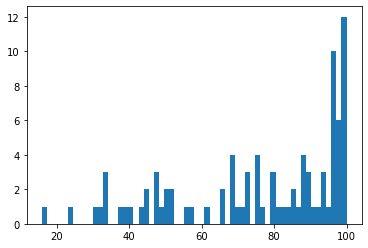

In [28]:
len_docs = [len(question['documents']) for question in questions['questions']]
plt.hist(len_docs, bins = 60)
plt.show()

In [29]:
pd.Series(len_docs).describe()

count     90.000000
mean      75.944444
std       23.060429
min       16.000000
25%       58.000000
50%       83.500000
75%       96.000000
max      100.000000
dtype: float64

## Saving to disk

In [30]:
save_json(questions, SAVING_PATH)

In [32]:
print(LOAD_QUESTIONS)

/datasets/johan_tests_original_format/merged_training_docs/test_original_10b-testset5.json
